In [57]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [58]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true;
# function code_toggle() {
# if (code_show){
# $('div.input').hide();
# } else {
# $('div.input').show();
# }
# code_show = !code_show
# }
# $( document ).ready(code_toggle);
# </script>
# The code for this notebook is hidden for easier reading.
# To toggle it on/off, please click <a href="javascript:code_toggle()">here</a>.''')

# Questions for Debjit: 

<span class="burk">1.  Why did the initial data preparation drill suggest that 'murder' and 'robbery' be recoded as categorical features? Does this choice impact the assumptions and model outcomes?
<span class="burk">2.  Are all 4 assumptions equally weighted? If not, which are prioritized and why? Must I always attempt to fix violated assumptions and if so, how far can I go before I'm over-engineering features?</span> 
<span class="burk">3.  When evaluating a model using holdout groups and/or cross-validation, should I check assumptions for the testing dataset as well? Why or why not?</span></span> 

# Cleaning & Feature Engineering

**Data: Crime In New York - [2013](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv).**

**I created a dataframe to hold the following features and the target variable - property crime:** 
-  'population' (Continuous)
-  'population_squared' (Continuous)
-  'murder' (Categorical)
-  'robbery' (Categorical)

In [59]:
path = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'
crime = pd.read_csv(path)

In [60]:
pd.options.mode.chained_assignment = None

crime.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','aggravated_assault','property_crime','burglary','larceny_theft','vehicle_theft','arson']
crime.drop(labels=[0,1,2,3,352,353,354],axis=0,inplace=True)
crime.drop(labels=['city'],axis=1,inplace=True)

columns = list(crime.columns)
for column in columns:
     crime[column]=crime[column].str.replace(',','')

crime = crime.apply(pd.to_numeric)
crime['population_squared']=crime['population']**2
crime['burglary']=crime['burglary'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime['larceny_theft']=crime['larceny_theft'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime['murder']=crime['murder'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime['rape_legacy']=crime['rape_legacy'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime['robbery']=crime['robbery'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime['vehicle_theft']=crime['vehicle_theft'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime['violent_crime']=crime['violent_crime'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')



In [61]:
crime.head()

,population,violent_crime,murder,rape_revised,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson,population_squared
4,1861,0,0,NaN,0,0,0,12,1,1,0,0.0,3463321
5,2577,1,0,NaN,0,0,3,24,1,1,1,0.0,6640929
6,2846,1,0,NaN,0,0,3,16,1,1,0,0.0,8099716
7,97956,1,1,NaN,1,1,526,4090,1,1,1,NaN,9595377936
8,6388,1,0,NaN,1,1,16,223,1,1,1,NaN,40806544


In [62]:
crime.describe()

,population,violent_crime,murder,rape_revised,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson,population_squared
count,3.480000e+02,348.000000,348.000000,0.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,187.000000,3.480000e+02
mean,4.003763e+04,0.853448,0.140805,NaN,0.413793,0.600575,121.261494,792.606322,0.939655,0.979885,0.732759,1.871658,2.035547e+11
std,4.500374e+05,0.354168,0.348321,NaN,0.493221,0.490486,1706.131730,7659.724746,0.238467,0.140596,0.443157,10.693411,3.778876e+12
min,5.260000e+02,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.766760e+05
25%,3.003000e+03,1.000000,0.000000,NaN,0.000000,0.000000,1.000000,40.500000,1.000000,1.000000,0.000000,0.000000,9.018117e+06
50%,7.233500e+03,1.000000,0.000000,NaN,0.000000,1.000000,4.000000,112.500000,1.000000,1.000000,1.000000,0.000000,5.232568e+07
75%,1.842750e+04,1.000000,0.000000,NaN,1.000000,1.000000,14.000000,341.000000,1.000000,1.000000,1.000000,1.000000,3.397536e+08
max,8.396126e+06,1.000000,1.000000,NaN,1.000000,1.000000,31767.000000,141971.000000,1.000000,1.000000,1.000000,132.000000,7.049493e+13


## TOGGLE: UNCOMMENT TO EXCLUDE NEW YORK & OTHER OUTLIERS

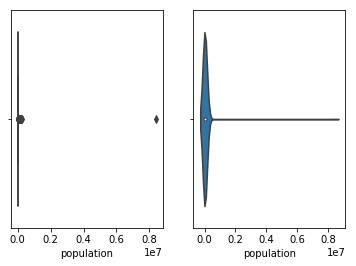

In [63]:
plt.subplot(121)
population = sns.boxplot(crime['population'])
plt.subplot(122)
population = sns.violinplot(crime['population'])

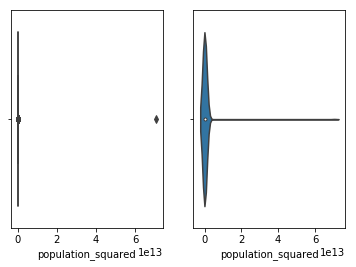

In [64]:
plt.subplot(121)
population_squared = sns.boxplot(crime['population_squared'])
plt.subplot(122)
population = sns.violinplot(crime['population_squared'])

In [65]:
columns = list(crime[['population','population_squared']].columns)
for column in columns: 
    q25 = crime[column].quantile(0.25)
    q75 = crime[column].quantile(0.75)
    iqr = q75 - q25
    maximum = q75 + (iqr * 1.5)
    crime=crime.where(crime[column] < maximum)

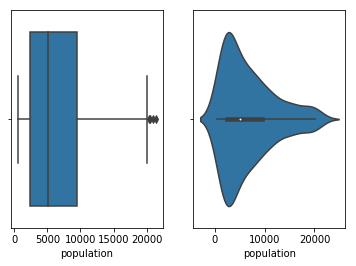

In [66]:
plt.subplot(121)
population = sns.boxplot(crime['population'])
plt.subplot(122)
population = sns.violinplot(crime['population'])

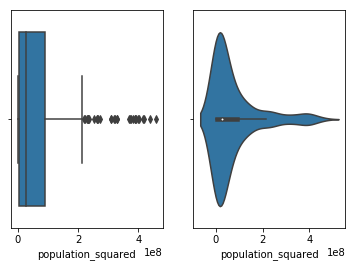

In [67]:
plt.subplot(121)
population_squared = sns.boxplot(crime['population_squared'])
plt.subplot(122)
population_squared = sns.violinplot(crime['population_squared'])

In [68]:
crime.describe()

,population,violent_crime,murder,rape_revised,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson,population_squared
count,274.000000,274.000000,274.000000,0.0,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,151.000000,2.740000e+02
mean,6730.492701,0.813869,0.051095,NaN,0.310219,0.500000,6.003650,130.014599,0.923358,0.974453,0.660584,0.337748,7.301594e+07
std,5274.271168,0.389925,0.220594,NaN,0.463430,0.500915,8.831553,151.249060,0.266510,0.158069,0.474378,0.847643,1.039372e+08
min,526.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.766760e+05
25%,2467.750000,1.000000,0.000000,NaN,0.000000,0.000000,1.000000,31.000000,1.000000,1.000000,0.000000,0.000000,6.089970e+06
50%,5133.500000,1.000000,0.000000,NaN,0.000000,0.500000,3.000000,73.500000,1.000000,1.000000,1.000000,0.000000,2.635293e+07
75%,9517.000000,1.000000,0.000000,NaN,1.000000,1.000000,7.000000,171.000000,1.000000,1.000000,1.000000,0.000000,9.057329e+07
max,21397.000000,1.000000,1.000000,NaN,1.000000,1.000000,64.000000,949.000000,1.000000,1.000000,1.000000,5.000000,4.578316e+08


# Initial Model

## Train-Test Split

In [69]:
crime = crime.replace([np.inf, -np.inf], np.nan).dropna(how="all")

In [70]:
y = crime['property_crime']
X = crime[['murder','population','population_squared','robbery']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

## Fitting to Training Data

In [71]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, y_train))


Coefficients: 
 [ 4.70323001e+01  1.58564946e-02 -2.03289592e-07  8.56948721e+01]

Intercept: 
 -14.969961136813481

R-Squared:
0.5006980394168676


In [72]:
crime_train = pd.concat([X_train, y_train], axis=1)
lf = 'property_crime ~ murder + population + population_squared + robbery'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     33.09
Date:                Sat, 03 Mar 2018   Prob (F-statistic):           4.21e-19
Time:                        18:25:47   Log-Likelihood:                -817.87
No. Observations:                 137   AIC:                             1646.
Df Residuals:                     132   BIC:                             1660.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -14.9700     21

# Checking Assumptions

## Linear Relationship

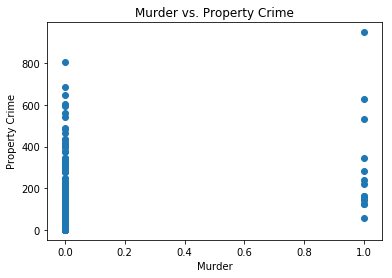

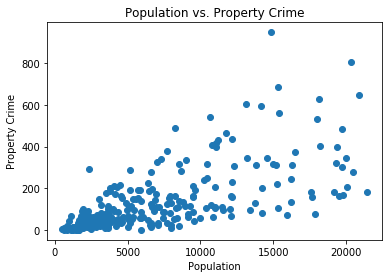

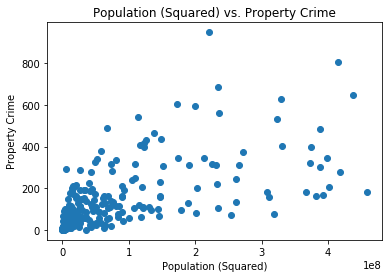

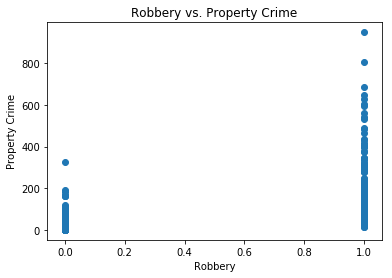

In [73]:
plt.scatter(y=crime['property_crime'], x=crime['murder'])
plt.ylabel('Property Crime')
plt.xlabel('Murder')
plt.title('Murder vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['population'])
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['population_squared'])
plt.ylabel('Property Crime')
plt.xlabel('Population (Squared)')
plt.title('Population (Squared) vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['robbery'])
plt.ylabel('Property Crime')
plt.xlabel('Robbery')
plt.title('Robbery vs. Property Crime')
plt.show()

## Multivariate Normality

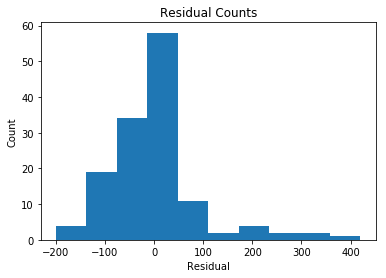

In [74]:
predicted = regr.predict(X_train).ravel()
actual = y_train
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## Homoscedasticity

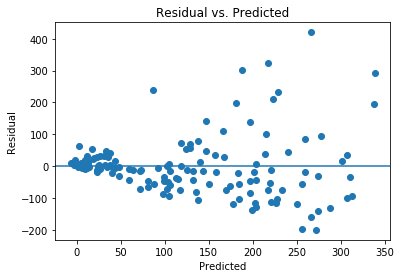

In [75]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Low Multicollinearity

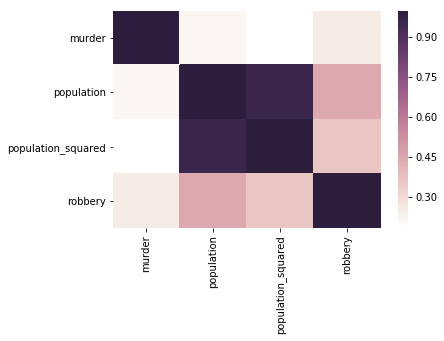

In [76]:
correlation_matrix = X_train.corr()
multicollinearity = sns.heatmap(correlation_matrix,cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

# Feature Reengineering

**Decisions:**
-  Added 'burglary' attempting to improve the coefficient of determination (R^2). 
-  Added 'larceny_theft' attempting to improve the coefficient of determination (R^2). 
-  Added 'vehicle_theft' attempting to improve the coefficient of determination (R^2). 
-  Dropped 'murder' based on its p-value. 
-  Dropped 'population_squared' based on its p-value.

**Revised Feature Set:**
-  'burglary'
-  'larceny_theft'
-  'population'
-  'robbery'
-  'vehicle_theft'

# Revised Model 

In [77]:
y = crime['property_crime']
X = crime[['burglary','larceny_theft','population','robbery','vehicle_theft']]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [79]:
crime_train = pd.concat([X_train, y_train], axis=1)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, y_train))


Coefficients: 
 [5.21637167e+00 8.78580755e+00 1.19355481e-02 9.07350459e+01
 9.50466519e+00]

Intercept: 
 -22.752277857416544

R-Squared:
0.49289710858120583


In [80]:
lf = 'property_crime ~ burglary + larceny_theft + population + robbery + vehicle_theft'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     25.47
Date:                Sat, 03 Mar 2018   Prob (F-statistic):           7.01e-18
Time:                        18:25:49   Log-Likelihood:                -818.93
No. Observations:                 137   AIC:                             1650.
Df Residuals:                     131   BIC:                             1667.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -22.7523    103.205     -0.220

# Re-Checking Assumptions

## Linear Relationship

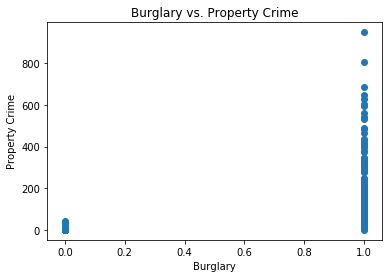

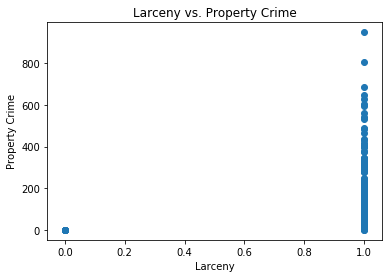

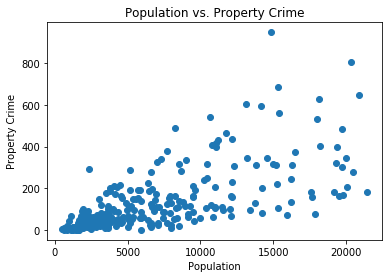

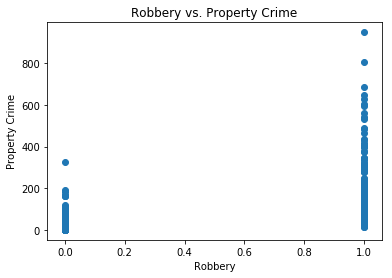

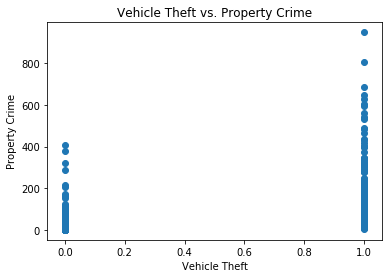

In [81]:
plt.scatter(y=crime['property_crime'], x=crime['burglary'])
plt.ylabel('Property Crime')
plt.xlabel('Burglary')
plt.title('Burglary vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['larceny_theft'])
plt.ylabel('Property Crime')
plt.xlabel('Larceny')
plt.title('Larceny vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['population'])
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['robbery'])
plt.ylabel('Property Crime')
plt.xlabel('Robbery')
plt.title('Robbery vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['vehicle_theft'])
plt.ylabel('Property Crime')
plt.xlabel('Vehicle Theft')
plt.title('Vehicle Theft vs. Property Crime')
plt.show()

## Multivariate Normality

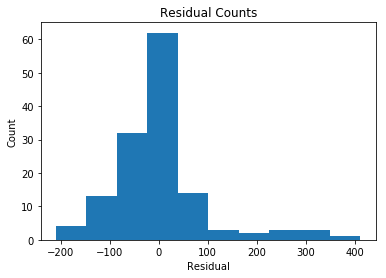

In [82]:
predicted = regr.predict(X_train).ravel()
actual = y_train
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## Homoscedasticity

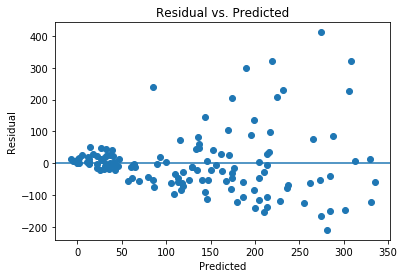

In [83]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Low Multicollinearity 

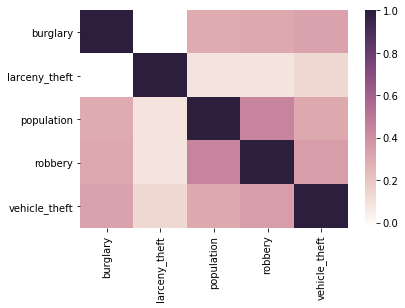

In [84]:
correlation_matrix = X_train.corr()
multicollinearity = sns.heatmap(correlation_matrix, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

# Final Model 

## Feature Finalization

**Decisions:**
-  Added 'violent_crime' attempting to improve the coefficient of determination (R^2). 
-  Dropped 'burglary' based on its p-value.
-  Dropped 'larceny_theft' based on its p-value. 
-  Dropped 'robbery' based on its r. 
-  Dropped 'vehicle_theft' based on its p-value.

**Final Feature Set:**
-  'population'
-  'robbery'
-  'violent_crime'

In [85]:
y = crime['property_crime']
X = crime[['population','violent_crime']]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [87]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, y_train))


Coefficients: 
 [1.47730080e-02 5.92756604e+01]

Intercept: 
 -22.975658841073994

R-Squared:
0.4203106464947137


In [88]:
crime_train = pd.concat([X_train, y_train], axis=1)
lf = 'property_crime ~ population + violent_crime'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     48.58
Date:                Sat, 03 Mar 2018   Prob (F-statistic):           1.36e-16
Time:                        18:25:52   Log-Likelihood:                -828.09
No. Observations:                 137   AIC:                             1662.
Df Residuals:                     134   BIC:                             1671.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -22.9757     21.481     -1.070

## Final Assumptions Check 

### Linear Relationship

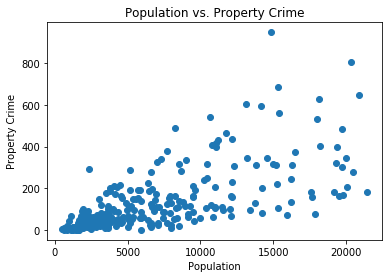

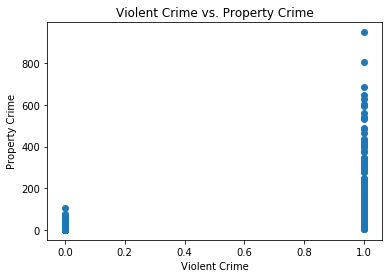

In [89]:
plt.scatter(y=crime['property_crime'], x=crime['population'])
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['violent_crime'])
plt.ylabel('Property Crime')
plt.xlabel('Violent Crime')
plt.title('Violent Crime vs. Property Crime')
plt.show()

### Multivariate Normality

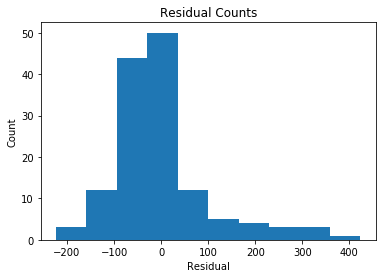

In [90]:
predicted = regr.predict(X_train).ravel()
actual = y_train
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### Homoscedasticity

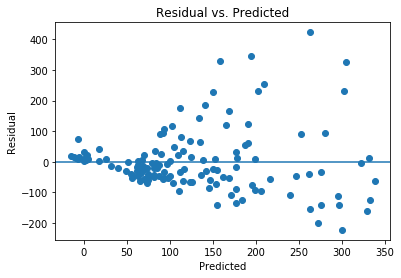

In [91]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Low Multicollinearity

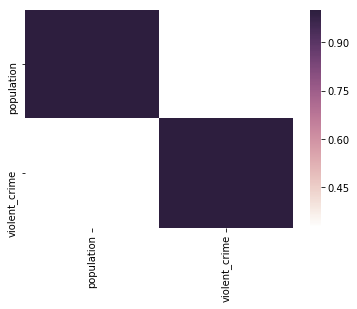

In [92]:
correlation_matrix = X_train.corr()
multicollinearity = sns.heatmap(correlation_matrix, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

# Final Model Evaluation: In-Sample

In [93]:
y = crime['property_crime']
X = crime[['population','violent_crime']]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [95]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Prediction Coefficient of Determination (R^2): {:.2f}%.".format(regr.score(X_test,y_pred)*100))

Prediction Coefficient of Determination (R^2): 100.00%.


# Final Model Evaluation: Out-of-Sample

**Data: Crime In New York - [2014](https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls/output.xls).**

**Because my finalized model uses 'population', and 'violent_crime' to explain 'property_crime', I've used the same features to evaluate out-of-sample prediction of the target.** 

## Cleaning

In [96]:
path = 'C:/Users/missn/Documents/Thinkful/CSV Datasets/Unit 2/Unit 2 Lesson 4/Regression NYC Crime Prediction/NYC Crime 2014.csv'
crime_validation = pd.read_csv('C:/Users/missn/Documents/Thinkful/CSV Datasets/Unit 2/Unit 2 Lesson 4/Regression NYC Crime Prediction/NYC Crime 2014.csv')

In [97]:
pd.options.mode.chained_assignment = None

crime_validation.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','aggravated_assault','property_crime','burglary','larceny_theft','vehicle_theft','arson','unknown']
crime_validation.drop(labels=[0,1,2,3,352,353,354],axis=0,inplace=True)
crime_validation.drop(labels=['city','unknown'],axis=1,inplace=True)

columns = list(crime_validation.columns)
for column in columns:
      crime_validation[column]=crime_validation[column].str.replace(',','')

crime_validation = crime_validation.apply(pd.to_numeric)
crime_validation['population_squared']=crime_validation['population']**2
crime_validation['aggravated_assault']=crime_validation['burglary'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime_validation['burglary']=crime_validation['burglary'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime_validation['larceny_theft']=crime_validation['larceny_theft'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime_validation['murder']=crime_validation['murder'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime_validation['rape_legacy']=crime_validation['robbery'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime_validation['robbery']=crime_validation['robbery'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
crime_validation['vehicle_theft']=crime_validation['vehicle_theft'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')

In [98]:
crime_validation.head()

,population,violent_crime,murder,rape_revised,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson,population_squared
4,1851.0,0.0,0,NaN,0,0,1,11.0,1,1,0,0.0,3.426201e+06
5,2568.0,2.0,0,NaN,1,1,1,49.0,1,1,1,0.0,6.594624e+06
6,820.0,0.0,0,0.0,0,0,0,1.0,0,1,0,0.0,6.724000e+05
7,2842.0,1.0,0,NaN,0,0,0,17.0,0,1,0,0.0,8.076964e+06
8,98595.0,802.0,1,54.0,1,1,1,3888.0,1,1,1,12.0,9.720974e+09


In [99]:
crime_validation.describe()

,population,violent_crime,murder,rape_revised,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson,population_squared
count,3.660000e+02,366.000000,373.000000,224.000000,373.000000,373.000000,373.000000,365.000000,373.000000,373.000000,373.000000,362.000000,3.660000e+02
mean,3.801518e+04,184.718579,0.155496,15.544643,0.538874,0.538874,0.903485,699.723288,0.903485,0.973190,0.707775,1.428177,1.971241e+11
std,4.429616e+05,2649.633068,0.362864,147.219697,0.499156,0.499156,0.295693,7152.724513,0.295693,0.161744,0.455396,8.027072,3.753399e+12
min,7.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.241000e+03
25%,2.638750e+03,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,25.000000,1.000000,1.000000,0.000000,0.000000,6.963182e+06
50%,6.564500e+03,5.000000,0.000000,1.000000,1.000000,1.000000,1.000000,75.000000,1.000000,1.000000,1.000000,0.000000,4.309293e+07
75%,1.536650e+04,17.000000,0.000000,4.000000,1.000000,1.000000,1.000000,270.000000,1.000000,1.000000,1.000000,1.000000,2.361345e+08
max,8.473938e+06,50564.000000,1.000000,2190.000000,1.000000,1.000000,1.000000,135747.000000,1.000000,1.000000,1.000000,135.000000,7.180763e+13


## TOGGLE: UNCOMMENT TO EXCLUDE NEW YORK & OTHER OUTLIERS

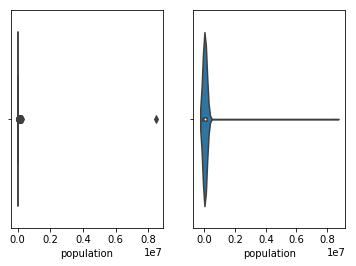

In [100]:
plt.subplot(121)
population = sns.boxplot(crime_validation['population'])
plt.subplot(122)
population = sns.violinplot(crime_validation['population'])

In [101]:
q25 = crime_validation['population'].quantile(0.25)
q75 = crime_validation['population'].quantile(0.75)
iqr = q75 - q25
maximum = q75 + (iqr * 1.5)
crime_validation=crime_validation.where(crime_validation['population'] < maximum)

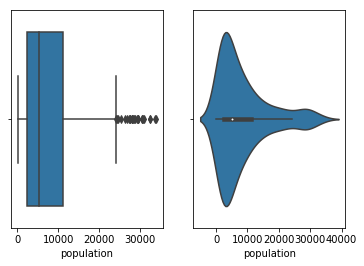

In [102]:
plt.subplot(121)
population = sns.boxplot(crime_validation['population'])
plt.subplot(122)
population = sns.violinplot(crime_validation['population'])

## Cross-Validation

In [103]:
crime_validation = crime_validation.replace([np.inf, -np.inf], np.nan).dropna(how="all")

In [104]:
y_test = crime_validation['property_crime']
X_test = crime_validation[['population','violent_crime']]

In [105]:
regr = linear_model.LinearRegression()
scores = cross_val_score(regr, X_test, y_test, cv=5, scoring = 'explained_variance')
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').